## Exeter 2020-3 Observations 

In [1]:
import s3fs
import pandas as pd
import json
import numpy as np
from datetime import datetime as dt
import datetime
import sqlite3
from matplotlib import pyplot as plt

from pygments import highlight
from pygments.lexers import SqlLexer
from pygments.formatters import HtmlFormatter
from IPython.display import HTML, display

In [2]:
## !time wget https://datadeloro0tutorials.s3.us-west-2.amazonaws.com/regAB/absee/exeter_simple.db

In [3]:
S3FS = s3fs.S3FileSystem(anon=True)
S3FS.download("s3://datadeloro0tutorials/regAB/absee/exeter_simple.db" \
    , "./exeter_simple.db")

PermissionError: Access Denied

In [4]:
S3FS = s3fs.S3FileSystem()
S3FS.download("s3://datadeloro0tutorials/regAB/absee/exeter_simple.db" \
    , "./exeter_simple.db")

[None]

In [5]:
con = sqlite3.connect("exeter_simple.db")

Text(0.5, 1.0, 'Accounts Dropped by Month')

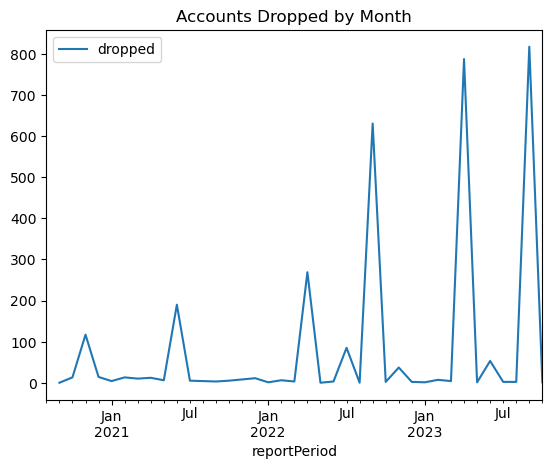

In [6]:
freqT = """select {fn}, count(*) as n
from {tn}
group by 1 order by 1"""
dateCountR = pd.read_sql(freqT.format(fn="reportingPeriodBeginningDate", tn="history"), con)
dateCountR["dropped"] = -dateCountR["n"].diff()
dateCountR["reportPeriod"] = [datetime.datetime.strptime(x, "%Y-%m-%d") \
                              for x in dateCountR["reportingPeriodBeginningDate"]]
# dateCountR.head(3)
fig, ax = plt.subplots()
dateCountR.plot("reportPeriod", "dropped", ax=ax)
ax.set_title("Accounts Dropped by Month")

In [8]:
qT = open('sql/lastEntryZeroBal.sql').read()
display(HTML(data=highlight(qT, SqlLexer(), HtmlFormatter())))

#### check for bad joins

In [13]:
pd.read_sql(qT.format(final="select * from checker order by cten"), con)

,cten,n
0,0maxrep,43589
1,1early,3131
2,2last,3131


#### looking at last zeroBalanceCode

In [14]:
pd.read_sql(qT.format(final="select * from report"), con)

,zeroBalanceCode,n
0,1.0,1
1,2.0,2667
2,3.0,462
3,4.0,1


#### looking at delinquenct level on  last
They are setting delinquency to 0 when setting 0 balance flag

In [17]:
earlyLastR = pd.read_sql(qT.format(final="select * from lastentry"), con)
pd.crosstab(earlyLastR["zeroBalanceCode"] \
            , earlyLastR["currentDelinquencyStatus"])

currentDelinquencyStatus,0
zeroBalanceCode,
1.0,1
2.0,2667
3.0,462
4.0,1


In [17]:
pd.crosstab(earlyLastR["zeroBalanceCode"] \
            , earlyLastR["currentDelinquencyStatus"])

currentDelinquencyStatus,0
zeroBalanceCode,
1.0,1
2.0,2667
3.0,462
4.0,1


In [41]:
curDelS = """select assetNumber	reportingPeriodBeginningDate 
    , zeroBalanceCode, currentDelinquencyStatus
from history"""
curDelR = pd.read_sql(curDelS, con)
curDelR.groupby("zeroBalanceCode")["currentDelinquencyStatus"] \
    .describe()

,count,mean,std,min,25%,50%,75%,max
zeroBalanceCode,,,,,,,,
1.0,428381.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
2.0,2814.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
3.0,464.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
4.0,151906.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
nan,1079781.0,11.122406,25.05756,0.0,0.0,0.0,10.0,987.0


#### The 3rd Party Sales are Chargeoffs

In [44]:
qT  = open("sql/delinquencyBeforeCO.sql").read()
multiEndR = pd.read_sql(qT.format(final="select * from overlap order by cten"), con)
multiEndR

,cten,n
0,00 accounts,43589
1,01 chargeoff,9317
2,02 repurchase,464
3,03 third party,2814
4,12 co and rep,1
5,13 co and sold,2812
6,23 repurchase and sold,0
7,30 just everything,0


#### Looking at full delinquency histories for CO

In [45]:
delHistR = pd.read_sql(qT.format(final="select * from cohist order by 1, 2"), con)
delHistR.shape

(340279, 9)

In [48]:
exampleL = list(set(delHistR.assetNumber))

In [50]:
i = 0
delHistR.query("assetNumber == %d" %(exampleL[i])).head(6)

,assetNumber,reportingPeriodBeginningDate,zeroBalanceCode,currentDelinquencyStatus,totalActualAmountPaid,modificationtypecode,reportingPeriodModificationIndicator,repossessedIndicator,recoveredAmount
214154,210622629922654301,2020-08-01,nan,4,0.0,NaN,0,0,0.0
214155,210622629922654301,2020-09-01,nan,34,0.0,NaN,0,0,0.0
214156,210622629922654301,2020-10-01,nan,65,0.0,NaN,0,0,NaN
214157,210622629922654301,2020-11-01,nan,95,320.0,NaN,0,0,NaN
214158,210622629922654301,2020-12-01,4.0,0,0.0,1.0,1,0,0.0
214159,210622629922654301,2021-01-01,4.0,0,0.0,NaN,0,0,0.0


In [52]:
i = 1
delHistR.query("assetNumber == %d" %(exampleL[i])).head(8)

,assetNumber,reportingPeriodBeginningDate,zeroBalanceCode,currentDelinquencyStatus,totalActualAmountPaid,modificationtypecode,reportingPeriodModificationIndicator,repossessedIndicator,recoveredAmount
201102,210584229921454301,2020-08-01,nan,0,800.7,NaN,0,0,0.0
201103,210584229921454301,2020-09-01,nan,2,0.0,NaN,0,0,0.0
201104,210584229921454301,2020-10-01,nan,33,0.0,NaN,0,0,NaN
201105,210584229921454301,2020-11-01,nan,63,0.0,NaN,0,0,NaN
201106,210584229921454301,2020-12-01,nan,94,0.0,NaN,0,0,NaN
201107,210584229921454301,2021-01-01,nan,125,0.0,NaN,0,1,NaN
201108,210584229921454301,2021-02-01,4.0,0,0.0,1.0,1,1,6069.0
201109,210584229921454301,2021-03-01,4.0,0,0.0,NaN,0,1,NaN
